In [1]:
!pip install matplotlib pandas

  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached pandas-2.3.0-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.5-cp312-cp312-win_amd64.whl.metadata (109 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached numpy-2.3.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached pillow-11.3.0-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached pandas-2.3.0-cp312-cp312-win_amd64.whl (11.0 MB)
Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl (223 kB)
Using cached cycler-0.12.1-p


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import re
from typing import List, Dict, Any, Tuple
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Step 1: Document Classification
def detect_document_type(document_text: str, metadata: Dict[str, Any] = None) -> str:
    if metadata and "source" in metadata:
        if "github" in metadata["source"].lower():
            return "code"
        if "confluence" in metadata["source"].lower():
            return "technical"
        if "jira" in metadata["source"].lower():
            return "support"
    
    # Then check content patterns
    code_pattern = re.compile(r'```[\w]*\n|def\s+\w+\(|class\s+\w+[:\(]|import\s+\w+|from\s+\w+\s+import')
    if code_pattern.search(document_text):
        return "code"
    
    if re.search(r'step\s+\d+|procedure|how\s+to|tutorial', document_text, re.IGNORECASE):
        return "tutorial"
        
    if re.search(r'policy|requirement|compliance|must\s+not|shall|should', document_text, re.IGNORECASE):
        return "policy"
        
    # Default to technical documentation
    return "technical"

In [4]:
test_docs = {
    "code": "```python\ndef hello_world():\n    print('Hello world')\n```",
    "tutorial": "Step 1: Install the package\nStep 2: Configure settings",
    "policy": "Security Policy\nAll employees must comply with the following requirements:",
    "technical": "API Documentation\nThis endpoint returns user data in JSON format."
}

In [5]:
for doc_type, content in test_docs.items():
    detected = detect_document_type(content)
    print(f"Expected: {doc_type}, Detected: {detected}, Correct: {doc_type == detected}")


Expected: code, Detected: code, Correct: True
Expected: tutorial, Detected: tutorial, Correct: True
Expected: policy, Detected: policy, Correct: True
Expected: technical, Detected: technical, Correct: True


In [6]:

# Step 2: Chunking Strategies for Different Document Types

def chunk_technical_document(document_text: str) -> List[str]:
    """Chunks technical documents by sections and paragraphs."""
    
    # Split by headers (##, ###) and then by paragraphs
    sections = re.split(r'(?m)^#{2,3}\s+', document_text)
    chunks = []
    
    for section in sections:
        if not section.strip():
            continue
            
        # Further split large sections into paragraphs
        if len(section) > 1000:
            paragraphs = re.split(r'\n\n+', section)
            chunks.extend([p for p in paragraphs if p.strip()])
        else:
            chunks.append(section)
            
    return chunks


In [7]:
def chunk_code_document(document_text: str) -> List[str]:
    """Chunks code documents preserving function/class definitions."""
    
    # Identify code blocks
    code_blocks = re.split(r'```(?:\w+)?\n', document_text)
    chunks = []
    
    for i, block in enumerate(code_blocks):
        if i % 2 == 1:  # This is a code block
            # Keep code blocks intact
            chunks.append(block)
        else:  # This is regular text
            # Split regular text by paragraphs
            text_chunks = re.split(r'\n\n+', block)
            chunks.extend([chunk for chunk in text_chunks if chunk.strip()])
            
    return chunks

In [8]:
def chunk_policy_document(document_text: str) -> List[str]:
    """Chunks policy documents preserving policy items and requirements."""
    
    # Split by policy sections and numbered items
    sections = re.split(r'(?m)^#{2,3}\s+|^\d+\.\s+', document_text)
    chunks = []
    
    for section in sections:
        if not section.strip():
            continue
            
        # Keep policy requirements together
        if len(section) > 1200:
            subsections = re.split(r'\n\n+', section)
            chunks.extend([s for s in subsections if s.strip()])
        else:
            chunks.append(section)
            
    return chunks

In [9]:
def chunk_tutorial_document(document_text: str) -> List[str]:
    """Chunks tutorial documents preserving step sequences."""
    
    # Split by step headers but keep sequential steps together
    step_pattern = re.compile(r'(?m)^Step\s+\d+:|^#{2,3}\s+Step\s+\d+')
    sections = step_pattern.split(document_text)
    
    chunks = []
    current_chunk = ""
    
    for section in sections:
        if not section.strip():
            continue
            
        # Group related steps together
        if len(current_chunk) + len(section) < 1000:
            current_chunk += section
        else:
            if current_chunk:
                chunks.append(current_chunk)
            current_chunk = section
            
    if current_chunk:
        chunks.append(current_chunk)
        
    return chunks

In [10]:
# Step 3: Main Adaptive Chunking Function
def adaptive_chunk_document(document_text: str, metadata: Dict[str, Any] = None) -> List[str]:
    """Applies the appropriate chunking strategy based on document type."""
    
    # Detect document type
    doc_type = detect_document_type(document_text, metadata)
    
    # Apply appropriate chunking strategy
    if doc_type == "code":
        return chunk_code_document(document_text)
    elif doc_type == "policy":
        return chunk_policy_document(document_text)
    elif doc_type == "tutorial":
        return chunk_tutorial_document(document_text)
    else:  # technical or default
        return chunk_technical_document(document_text)


In [11]:
# Step 4: Document Processing Pipeline
def process_document(document_text: str, metadata: Dict[str, Any] = None) -> Tuple[List[str], str]:
    """Processes a document through the intelligent chunking pipeline."""
    
    # Detect document type
    doc_type = detect_document_type(document_text, metadata)
    
    # Apply chunking
    chunks = adaptive_chunk_document(document_text, metadata)
    
    return chunks, doc_type

In [12]:
# Step 5: Performance Evaluation
def evaluate_chunking_quality(chunks: List[str], original_text: str) -> Dict[str, float]:
    """Evaluates the quality of document chunking."""
    
    # Calculate basic metrics
    total_chunks = len(chunks)
    avg_chunk_size = sum(len(chunk) for chunk in chunks) / total_chunks if total_chunks > 0 else 0
    coverage = sum(len(chunk) for chunk in chunks) / len(original_text) if original_text else 0
    
    # Check for content preservation
    content_preserved = all(chunk in original_text for chunk in chunks)
    
    return {
        "total_chunks": total_chunks,
        "avg_chunk_size": avg_chunk_size,
        "coverage": coverage,
        "content_preserved": content_preserved
    }

In [13]:
example_documents = {
    "technical": """
    # Technical Guide to API Integration
    
    ## Overview
    This document explains how to integrate with our REST API.
    
    ## Authentication
    Authentication uses OAuth 2.0. Here's an example:
    ```python
    import requests
    
    def get_token(client_id, client_secret):
        url = "https://api.example.com/oauth/token"
        payload = {
            "client_id": client_id,
            "client_secret": client_secret,
            "grant_type": "client_credentials"
        }
        response = requests.post(url, data=payload)
        return response.json()["access_token"]
    ```
    ## Endpoints
    The following endpoints are available:
    - GET /users
    - POST /users
    - GET /products
    
    ## Error Handling
    Handle errors by checking the status code.
    """,
    
    "code": """
    # Code Repository Documentation
    ## Main Module
    
    ```python
    class DocumentProcessor:
        def __init__(self, config):
            self.config = config
            
        def process(self, document):
            # Process the document
            return processed_document
    ```
    
    ## Utility Functions
    
    ```python
    def parse_config(config_file):
        with open(config_file, 'r') as f:
            return json.load(f)
    ```
    """,
    
    "policy": """
    # Corporate Security Policy
    
    ## Data Protection Requirements
    
    1. All customer data must be encrypted at rest and in transit.
    2. Access to production data requires two-factor authentication.
    3. Data retention periods must comply with local regulations.
    
    ## Incident Response
    
    In case of a security incident, the following steps must be taken:
    1. Isolate affected systems
    2. Notify the security team within 1 hour
    3. Document all actions taken
    """,
    "tutorial": """
    # How to Deploy the Application
    
    ## Step 1: Environment Setup
    Install the required dependencies:
    - Node.js v14+
    - MongoDB
    - Redis
    
    ## Step 2: Configuration
    Copy the example config file and update with your settings:
    ```
    cp config.example.json config.json
    ```
    
    ## Step 3: Database Initialization
    Run the setup script:
    ```
    npm run db:setup
    ```
    
    ## Step 4: Start the Application
    Launch the application with:
    ```
    npm start
    ```
    """
}

    
    

In [14]:
# Process each document and collect results
results = {}

for doc_type, doc_text in example_documents.items():
    metadata = {"source": f"{doc_type}_source"}
    chunks, detected_type = process_document(doc_text, metadata)
    metrics = evaluate_chunking_quality(chunks, doc_text)
    
    results[doc_type] = {
        "detected_type": detected_type,
        "chunks": chunks,
        "metrics": metrics
    }


In [16]:
# Display results in a table
results_df = pd.DataFrame({
    "Document Type": [k for k in results.keys()],
    "Detected Type": [v["detected_type"] for v in results.values()],
    "Chunks Count": [v["metrics"]["total_chunks"] for v in results.values()],
    "Avg Chunk Size": [round(v["metrics"]["avg_chunk_size"], 2) for v in results.values()],
    "Content Preserved": [v["metrics"]["content_preserved"] for v in results.values()]
})


In [17]:
print("Results Summary:")
print(results_df)

Results Summary:
  Document Type Detected Type  Chunks Count  Avg Chunk Size  Content Preserved
0     technical          code             6          127.33               True
1          code          code             4          101.50               True
2        policy        policy             1          487.00               True
3      tutorial          code             8           60.00               True


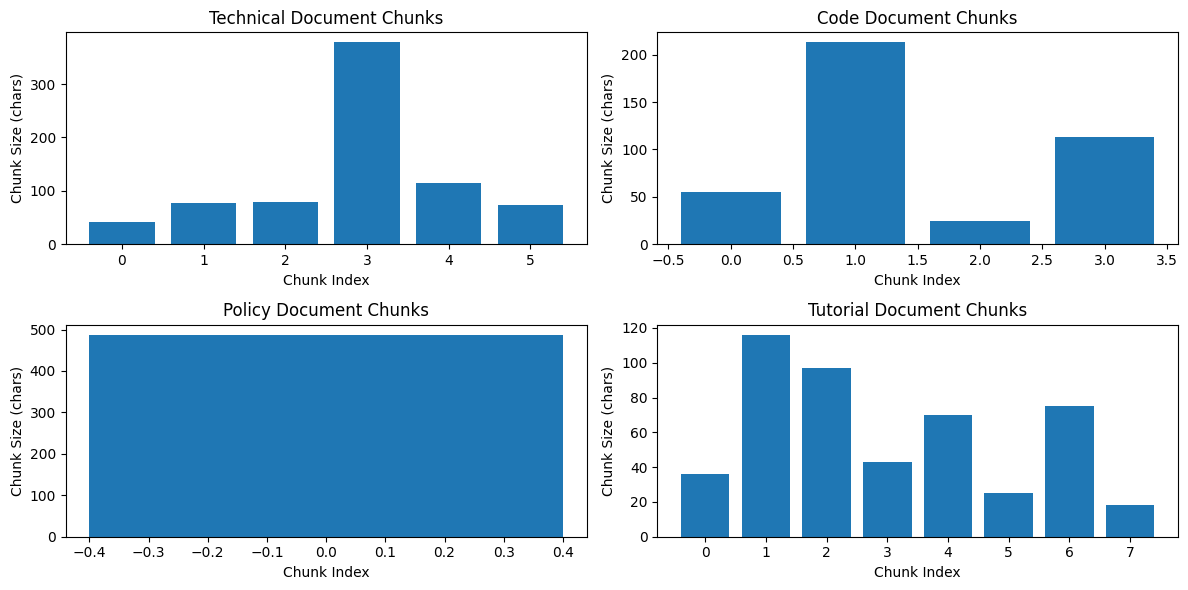

In [18]:
plt.figure(figsize=(12, 6))

for i, doc_type in enumerate(results.keys()):
    chunk_sizes = [len(chunk) for chunk in results[doc_type]["chunks"]]
    plt.subplot(2, 2, i+1)
    plt.bar(range(len(chunk_sizes)), chunk_sizes)
    plt.title(f"{doc_type.capitalize()} Document Chunks")
    plt.xlabel("Chunk Index")
    plt.ylabel("Chunk Size (chars)")

plt.tight_layout()
plt.show()

In [19]:
# Step 7: Example of processing a new document
def process_new_document(document_text, metadata=None):
    """Process a new document and show detailed results"""
    
    # Process the document
    chunks, doc_type = process_document(document_text, metadata)
    
    # Print results
    print(f"Detected document type: {doc_type}")
    print(f"Generated {len(chunks)} chunks\n")
    
    # Show chunk details
    for i, chunk in enumerate(chunks):
        print(f"Chunk {i+1} ({len(chunk)} chars):")
        # Show truncated chunk content
        preview = chunk[:100] + "..." if len(chunk) > 100 else chunk
        print(f"{preview}\n")
    
    # Evaluate chunking
    metrics = evaluate_chunking_quality(chunks, document_text)
    print("\nChunking Quality Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    return chunks, doc_type, metrics

In [20]:
sample_mixed_doc = """
# Product Documentation

## API Reference

```javascript
// Initialize the client
const client = new APIClient({
  apiKey: process.env.API_KEY,
  endpoint: 'https://api.example.com/v2'
});

// Make a request
async function getUsers() {
  return await client.users.list();
}
```

## Usage Policy

1. Rate limits: 100 requests per minute
2. Authentication tokens must be rotated every 30 days
3. All API access must be over HTTPS

## Tutorial: Getting Started

Step 1: Sign up for an API key
Step 2: Install the client library
Step 3: Make your first API call
"""

In [21]:
# Process the mixed document
print("\nProcessing Mixed Document Example:")
chunks, doc_type, metrics = process_new_document(sample_mixed_doc)


Processing Mixed Document Example:
Detected document type: code
Generated 7 chunks

Chunk 1 (24 chars):

# Product Documentation

Chunk 2 (16 chars):
## API Reference

Chunk 3 (217 chars):
// Initialize the client
const client = new APIClient({
  apiKey: process.env.API_KEY,
  endpoint: '...

Chunk 4 (16 chars):

## Usage Policy

Chunk 5 (131 chars):
1. Rate limits: 100 requests per minute
2. Authentication tokens must be rotated every 30 days
3. Al...

Chunk 6 (28 chars):
## Tutorial: Getting Started

Chunk 7 (99 chars):
Step 1: Sign up for an API key
Step 2: Install the client library
Step 3: Make your first API call



Chunking Quality Metrics:
total_chunks: 7
avg_chunk_size: 75.85714285714286
coverage: 0.9499105545617174
content_preserved: True


In [22]:
!pip install langchain chromadb

  Using cached langchain-0.3.26-py3-none-any.whl.metadata (7.8 kB)
  Using cached chromadb-1.0.15-cp39-abi3-win_amd64.whl.metadata (7.1 kB)
  Using cached langchain_core-0.3.68-py3-none-any.whl.metadata (5.8 kB)
  Using cached langchain_text_splitters-0.3.8-py3-none-any.whl.metadata (1.9 kB)
  Using cached langsmith-0.4.4-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached sqlalchemy-2.0.41-cp312-cp312-win_amd64.whl.metadata (9.8 kB)
  Using cached build-1.2.2.post1-py3-none-any.whl.metadata (6.5 kB)
  Using cached pybase64-1.4.1-cp312-cp312-win_amd64.whl.metadata (8.7 kB)
  Using cached uvicorn-0.35.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached posthog-5.4.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached onnxruntime-1.22.0-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
  Using cached opentelemetry_api-1.34.1-py3-none-any.whl.metadata (1.5 kB)
  Using cached opentelemetry_exporter_otlp_proto_grpc-1.34.1-py3-none-any.wh


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
from langchain.text_splitter import TextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings


In [26]:
# Create a custom LangChain text splitter using our adaptive chunking
class AdaptiveDocumentSplitter(TextSplitter):
    def __init__(self):
        super().__init__()
    
    def split_text(self, text):
        # Use our adaptive chunking
        chunks, _ = process_document(text)
        return chunks

In [30]:
embeddings = HuggingFaceEmbeddings()
splitter = AdaptiveDocumentSplitter()


C:\Users\harsh\AppData\Local\Temp\ipykernel_48628\605415494.py:1: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embeddings = HuggingFaceEmbeddings()


In [31]:
# Process documents
documents = [sample_mixed_doc]
chunks = []
for doc in documents:
    chunks.extend(splitter.split_text(doc))


In [33]:
# Create vector store
vectorstore = Chroma.from_texts(chunks, embeddings)

# Example query
query = "How do I make my first API call?"
results = vectorstore.similarity_search(query, k=2)

In [34]:
print("\nLangChain Integration Example:")
print(f"Query: {query}")
for i, doc in enumerate(results):
    print(f"\nResult {i+1}:")
    print(doc.page_content[:200] + "..." if len(doc.page_content) > 200 else doc.page_content)




LangChain Integration Example:
Query: How do I make my first API call?

Result 1:
Step 1: Sign up for an API key
Step 2: Install the client library
Step 3: Make your first API call


Result 2:
// Initialize the client
const client = new APIClient({
  apiKey: process.env.API_KEY,
  endpoint: 'https://api.example.com/v2'
});

// Make a request
async function getUsers() {
  return await client...
